In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from src.constants import PARAMS_STATIC_CART, PARAMS_STATIC_COMB
from src.kernels import local_lengthscale
from src.plot_helper import plot_local_lengthscale, plot_saver
import numpy as np 
import matplotlib.pyplot as plt
from src.optimize import optimize_params
import matplotlib.pyplot as plt
from src.forward_model import get_forward_measurement
from src.error_model import get_std
from src.load_data import get_sample_emission, load_saved_bolometer_data, load_magnetic_coords
from src.plot_helper import plot_emission, visualize_measurements
from src.metrics import *
from src.gp_inference import performGP

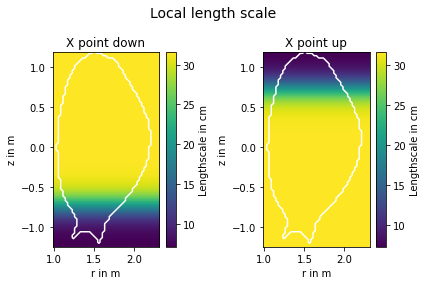

In [3]:
params_l = PARAMS_STATIC_CART[1:3]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,4))
plot_local_lengthscale(params_l, local_lengthscale, fig, ax1)
plot_local_lengthscale(params_l, local_lengthscale, fig, ax2,x_point_up=True)
fig.suptitle("Local length scale", fontsize=14)
ax1.set_title("X point down")
ax2.set_title("X point up")
ax1.set_ylabel("z in m")
ax2.set_ylabel("z in m")
ax1.set_xlabel("r in m")
ax2.set_xlabel("r in m")
plt.tight_layout()
plot_saver("../paper/sections/img/local_lengthscale.png", dpi=300, transparent=True)

In [3]:
from src.static_coords import r_coord, z_coord, r_coord_full, z_coord_full
mask = np.loadtxt("data/mask.txt")
full_mask = np.loadtxt("data/mask_fullres.txt")

1.9822199999999999
0.100120725
0.8216615915298462
-0.7650479777624318


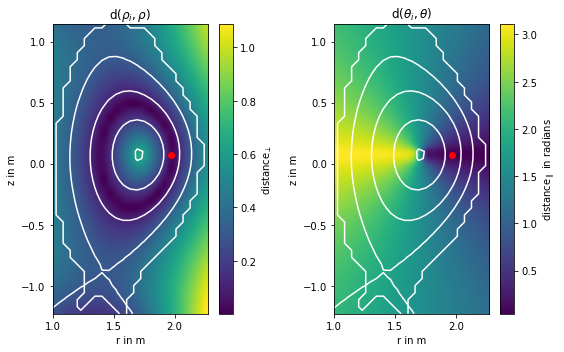

In [75]:
#magnetic_coords_36173 = np.load("data/time_series/shot36173mag_coords_0_10_20.npy")
mag_coords_at_t = load_magnetic_coords(204)

rho_0 = .7
rho_dist = np.abs(rho_0 - mag_coords_at_t[0])
theta_0 = 0
theta_dist = np.abs(theta_0 - mag_coords_at_t[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5))
img1 = ax1.imshow(rho_dist, extent=[r_coord[0], r_coord[-1], z_coord[0], z_coord[-1]], interpolation="spline36")
fig.colorbar(img1, ax=ax1, label=r'$\mathrm{distance}_{\perp}$')
ax1.contour(r_coord, z_coord, mask[::-1], levels=[0.5], colors="white")
ax1.contour(r_coord, z_coord, mag_coords_at_t[0][::-1,:], colors="white", levels=[.1, .5, .8,1],)

img2 = ax2.imshow(theta_dist, extent=[r_coord[0], r_coord[-1], z_coord[0], z_coord[-1]], interpolation="spline36")
fig.colorbar(img2, ax=ax2, label=r'$\mathrm{distance}_{\parallel}$ in radians')
ax2.contour(r_coord, z_coord, mask[::-1], levels=[0.5], colors="white")
ax2.contour(r_coord, z_coord, mag_coords_at_t[0][::-1,:], colors="white", levels=[.1, .5, .8,1],)


ax1.set_title(r'$\mathrm{d}(\rho_i, \rho)$')
ax2.set_title(r'$\mathrm{d}(\theta_i, \theta)$')
ax1.set_xlabel("r in m")
ax1.set_ylabel("z in m")
ax2.set_xlabel("r in m")
ax2.set_ylabel("z in m")

ri = 17
zi = 23
print(r_coord[ri])
print(z_coord[zi])
print(mag_coords_at_t[0, zi, ri])
print(mag_coords_at_t[1, zi, ri])

ax1.plot(1.97, 0.07, "o", color="red")
ax2.plot(1.97, 0.07, "o", color="red")

plt.tight_layout()
plot_saver("../paper/sections/img/magnetic_distance.png", dpi=350, transparent=True)

In [65]:
print(r_coord[17])
print(z_coord[23])
print(mag_coords_at_t[0, 22, 17])
print(mag_coords_at_t[1, 34, 17])


1.9822199999999999
0.100120725
0.769585371017456
-1.2739311753790463


In [5]:
transfer_full = np.loadtxt("data/full_transfer_volume.txt")
channel_25 = transfer_full[45].reshape(85,47)
plt.imshow(channel_25, extent=[r_coord_full[0], r_coord_full[-1], z_coord_full[0], z_coord_full[-1]])
plt.contour(r_coord_full, z_coord_full, full_mask[::-1], levels=[0.5], colors="white")
plt.xlabel("r in m")
plt.ylabel("z in m")
plt.title("Channel 30 of FHC camera", fontsize=10)
#plot_saver("../paper/sections/img/transfer_channel30.png", dpi=350, transparent=True)
print(z_coord)

[-1.2299911  -1.1721675  -1.1143375  -1.0565075  -0.99867475 -0.94084325
 -0.883012   -0.82518075 -0.76734925 -0.709518   -0.65168675 -0.59385525
 -0.536024   -0.47819275 -0.42036125 -0.36253    -0.30469875 -0.24686725
 -0.189036   -0.13120475 -0.0733734  -0.01554213  0.04228925  0.10012072
  0.15795175  0.215783    0.27361475  0.33144575  0.389277    0.44710875
  0.50493975  0.562771    0.62060225  0.678434    0.73626525  0.79409625
  0.85192775  0.909759    0.96759075  1.0254215   1.0832525   1.1410825 ]


In [5]:
from src.load_data import get_training_emission, map_training_to_real_shot
from src.plot_helper import plot_emission, visualize_measurements

training_emission = get_training_emission(62)
shotnumber, time = map_training_to_real_shot(62)
plot_emission(training_emission, title="Shot {} at t={}".format(shotnumber, time))

ImportError: cannot import name 'get_training_emission' from 'src.load_data' (/home/korbi/Nextcloud/Studium/gptomography-paper/code/src/load_data.py)

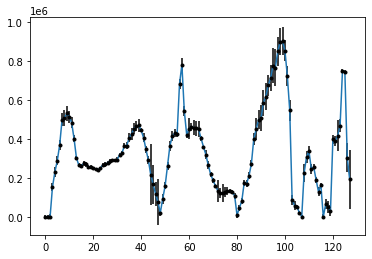

In [2]:
import matplotlib.pyplot as plt
from src.forward_model import get_measurement
from src.error_model import get_std

training_measurements = get_measurement(training_emission)
training_measurement_error = get_std(training_measurements)

plt.plot(training_measurements)
plt.errorbar(range(128), training_measurements,
                yerr=training_measurement_error, fmt=".", color="black")
fig, ax = plt.subplots(1,1)
visualize_measurements(training_measurements, fig, ax)

In [6]:

from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
def compare_emissions(  emissions, 
                        titles,
                        interpol="spline36", 
                        cmap="viridis", 
                        contour_color="white", 
                        adapt_colorscale=True,
                        figsize=(6.8,4.2),
                        custom_colorscale_label=""):

    wspace = 1 * (not adapt_colorscale)

    fig, axes = plt.subplots(1, len(emissions), sharey=adapt_colorscale, 
                    gridspec_kw = {'wspace':wspace, 'hspace':0}, 
                    figsize=figsize, 
                    constrained_layout=False)

    fig.suptitle(titles[0], fontsize=14)

    images = []

    for i, ax in enumerate(axes):

        vmin = 0
        vmax = emissions[0].max()/1000000
        if not adapt_colorscale:
            vmin = emissions[i].min()/1000000
            vmax = emissions[i].max()/1000000

        ax.contour(r_coord, z_coord, mask[::-1], levels=[0.5], colors=contour_color)
        img = ax.imshow(emissions[i]/1000000, interpolation=interpol, vmin=vmin, vmax=vmax,
                extent=[r_coord[0], r_coord[-1], z_coord[0], z_coord[-1]], cmap=cmap)
        images.append(img)
        ax.set_title(titles[i+1])
        #if i == 1:ax.set_xlabel("r in m")
        if i==0 or not adapt_colorscale: ax.set_ylabel("z in m")
        #if i>0: ax.set_yticks([])
        ax.set_xlabel("r in m")
    
    colorscale_label = (custom_colorscale_label if custom_colorscale_label
                        else "Emission in MW/m³")
    
    if adapt_colorscale:
        divider = make_axes_locatable(axes[-1])
        cax = divider.append_axes("right", size="8%", pad=0.05)
        fig.colorbar(images[0], cax=cax, label=colorscale_label)
    else:
        for i, ax in enumerate(axes):
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="8%", pad=0.05)
            fig.colorbar(images[i], cax=cax, label=colorscale_label)

        plt.tight_layout(rect=[0,0,1,0.1])

54077567349.94213
54077567349.94213


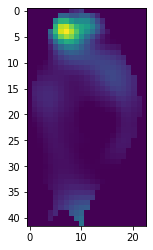

In [9]:
sample = 206

sample_emission = get_sample_emission(sample)
real_measurement = load_saved_bolometer_data(sample)
forward_measurement = get_forward_measurement(sample_emission)
mag_coords = load_magnetic_coords(sample)


fit_real, _ = performGP(real_measurement, PARAMS_STATIC_COMB,
                            kernel_function="combined_var_z", 
                            magnetic_coords = mag_coords, x_point_up=True)

fit_forward, _ = performGP(forward_measurement, PARAMS_STATIC_COMB,
                            kernel_function="combined_var_z", 
                            magnetic_coords = mag_coords, x_point_up=True)

#compare_emissions([sample_emission, fit_real, fit_forward], 
#                    ["Shot 36236 at t=4.6s", "a) sample emission", "b) fit with real data", "c) fit via forward model"], figsize=(7.8, 4.5))
plt.imshow(fit_forward)
#plot_saver("../paper/sections/img/fit_36354.png", dpi=350, transparent=True)
#plot_saver("../paper/sections/img/fit_36236.png", dpi=350, transparent=True)

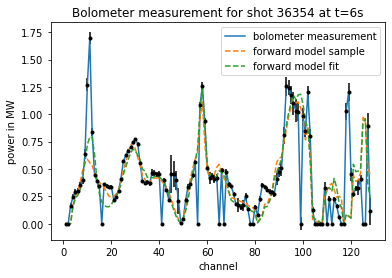

In [40]:
real_meas_err = get_std(real_measurement)
plt.plot(range(1,129), real_measurement/1000000, label="bolometer measurement")
plt.errorbar(range(1,129), real_measurement/1000000, yerr=real_meas_err/1000000, fmt=".", color="black")
plt.plot(range(1,129), get_forward_measurement(fit_real)/1000000, label="forward model sample", linestyle="--")
plt.plot(range(1,129), forward_measurement/1000000, label="forward model fit", linestyle="--")
plt.xlabel("channel")
plt.ylabel("power in MW")
plt.title("Bolometer measurement for shot 36354 at t=6s")
plt.legend()
plot_saver("../paper/sections/img/measurement_36354.png", dpi=350, transparent=True)

In [39]:
sample = 94

sample_emission = get_sample_emission(sample)
forward_measurement = get_forward_measurement(sample_emission)
mag_coords = load_magnetic_coords(sample)

params_opt_cart = optimize_params(forward_measurement, [500000, 0.1, 0.2], kernel_function="cartesian_var_z", x_point_up=True)
params_opt_comb = optimize_params(forward_measurement, [2.79e+05, 2.9e-01, 2.9e-02, 2.7e+05, 2e-01, 8], kernel_function="combined_var_z", magnetic_coords=mag_coords, x_point_up=True, xatol=10)
#params_opt_comb = [2.592e+05, 3.191e-01, 2.924e-02, 2.569e+05, 1.827e-01, 4.234e+00]

Function call 0: 1457.924
[5.e+05 1.e-01 2.e-01]
Function call 200: 1418.861
[7.23318649e+05 2.35898430e-01 8.04331309e-07]
Optimization terminated successfully.
         Current function value: 1418.860970
         Iterations: 180
         Function evaluations: 331
 final_simplex: (array([[ 7.23430943e+05,  2.35956637e-01,  2.39080852e-12],
       [ 7.23430216e+05,  2.35956507e-01, -1.36343610e-11],
       [ 7.23431349e+05,  2.35956684e-01, -1.49214816e-11],
       [ 7.23430317e+05,  2.35956363e-01, -5.97939005e-12]]), array([1418.86097023, 1418.86097023, 1418.86097023, 1418.86097023]))
           fun: 1418.860970225197
       message: 'Optimization terminated successfully.'
          nfev: 331
           nit: 180
        status: 0
       success: True
             x: array([7.23430943e+05, 2.35956637e-01, 2.39080852e-12])
Function call 0: 1409.066
[2.79e+05 2.90e-01 2.90e-02 2.70e+05 2.00e-01 8.00e+00]
Function call 200: 1380.661
[5.59127372e+05 3.21652748e-01 1.80933058e-02 3.236674

3279647754.2898273
70101331313.64384


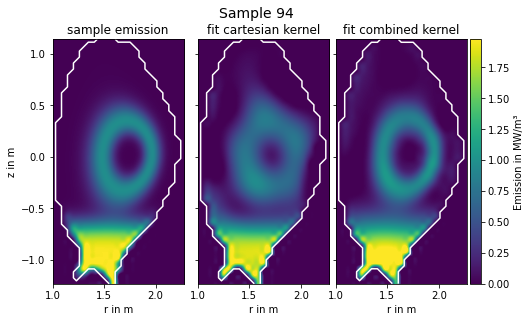

In [40]:
fit_cart, cov_cart_ = performGP(forward_measurement, params_opt_cart,
                            kernel_function="cartesian_var_z", 
                            magnetic_coords = mag_coords, x_point_up=True)

fit_comb, cov_comb = performGP(forward_measurement, params_opt_comb,
                            kernel_function="combined_var_z", 
                            magnetic_coords = mag_coords, x_point_up=True)

compare_emissions([sample_emission, fit_cart, fit_comb], 
                    ["Sample 94", "sample emission", "fit cartesian kernel", "fit combined kernel"], figsize=(7.8, 4.5))

plot_saver("../paper/sections/img/fit_synth94_2.png", dpi=350, transparent=True)

In [8]:
sample2 = 208

sample_emission2 = get_sample_emission(sample2)
forward_measurement2 = get_forward_measurement(sample_emission2)
mag_coords2 = load_magnetic_coords(sample2)

params_opt_cart2 = optimize_params(forward_measurement2, [500000, 0.1, 0.2], kernel_function="cartesian_var_z", x_point_up=False)
params_opt_comb2 = optimize_params(forward_measurement2, [400000, 0.1, 0.2, 150000, 0.2, 10], kernel_function="combined_var_z", magnetic_coords=mag_coords2, x_point_up=False,)


fit_cart2, cov_cart2 = performGP(forward_measurement2, params_opt_cart2,
                            kernel_function="cartesian_var_z", 
                            magnetic_coords = mag_coords2, x_point_up=False)

fit_comb2, cov_comb2 = performGP(forward_measurement2, params_opt_comb2,
                            kernel_function="combined_var_z", 
                            magnetic_coords = mag_coords2, x_point_up=False)

Function call 0: 1429.571
[5.e+05 1.e-01 2.e-01]
Optimization terminated successfully.
         Current function value: 1417.620578
         Iterations: 100
         Function evaluations: 184
 final_simplex: (array([[7.44986576e+05, 7.32132914e-02, 2.26085006e-01],
       [7.44987237e+05, 7.32132727e-02, 2.26085130e-01],
       [7.44987384e+05, 7.32132979e-02, 2.26085237e-01],
       [7.44987140e+05, 7.32133256e-02, 2.26084978e-01]]), array([1417.62057755, 1417.62057755, 1417.62057755, 1417.62057755]))
           fun: 1417.6205775502103
       message: 'Optimization terminated successfully.'
          nfev: 184
           nit: 100
        status: 0
       success: True
             x: array([7.44986576e+05, 7.32132914e-02, 2.26085006e-01])
Function call 0: 1434.828
[4.0e+05 1.0e-01 2.0e-01 1.5e+05 2.0e-01 1.0e+01]
Function call 200: 1415.9
[6.76931916e+05 6.78563803e-02 2.34753175e-01 1.53188926e+05
 2.39897140e-01 5.79673456e+00]
Function call 400: 1415.181
[6.25968047e+05 5.85695935e

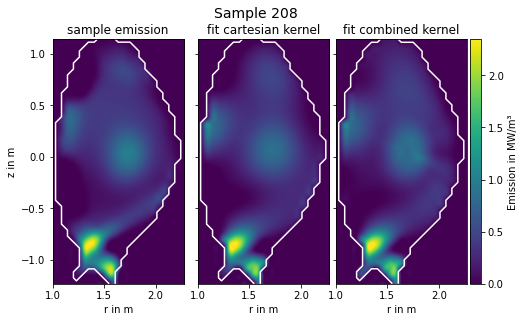

In [9]:
compare_emissions([sample_emission2, fit_cart2, fit_comb2], 
                    ["Sample 208", "sample emission", "fit cartesian kernel", "fit combined kernel"], figsize=(7.8, 4.5))

plot_saver("../paper/sections/img/fit_synth208_2.png", dpi=350, transparent=True)

0.4393100813775551
0.46138473098324195


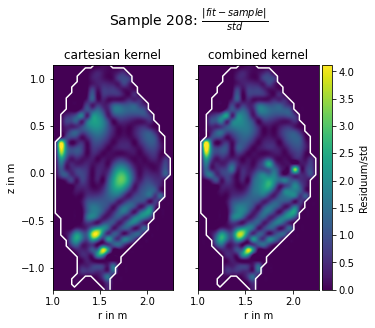

In [12]:

residuum_test = residuum(sample_emission2, fit_cart2, cov_cart2)
print(residuum_test.mean())
residuum_test2 = residuum(sample_emission2, np.abs(fit_cart2), np.abs(cov_comb2))
print(residuum_test2.mean())
compare_emissions([residuum_test*1e6, residuum_test2*1e6], 
                    [r"Sample 208: $\frac{|fit-sample|}{std}$", "cartesian kernel", "combined kernel"], figsize=(5.5, 4.6), custom_colorscale_label="Residuum/std")
plt.tight_layout()
plot_saver("../paper/sections/img/residuum208.png", dpi=350, transparent=True)

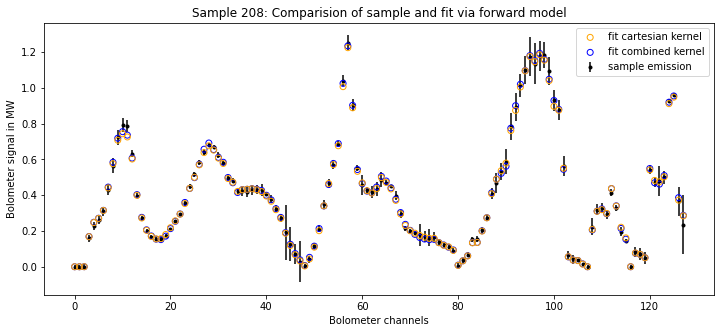

In [13]:
plt.figure(figsize=(12,5))
plt.errorbar(range(128), forward_measurement2/1e6,
                yerr=get_std(forward_measurement2)/1e6, fmt=".", color="black", zorder=-1, label="sample emission")
plt.scatter(range(128), get_forward_measurement(fit_cart2)/1e6, facecolors='none', edgecolors='orange', label="fit cartesian kernel", zorder=10)
plt.scatter(range(128), get_forward_measurement(fit_comb2)/1e6, facecolors='none', edgecolors='b', label="fit combined kernel")
plt.ylabel("Bolometer signal in MW")
plt.xlabel("Bolometer channels")
plt.legend()
plt.title("Sample 208: Comparision of sample and fit via forward model")
plot_saver("../paper/sections/img/forward_meas208_2.png", dpi=350, transparent=True)

Function call 0: 1438.699
[5.e+05 1.e-01 2.e-01]
Optimization terminated successfully.
         Current function value: 1419.136390
         Iterations: 103
         Function evaluations: 188
 final_simplex: (array([[8.48082538e+05, 8.74305529e-02, 1.92688336e-01],
       [8.48082603e+05, 8.74306221e-02, 1.92688446e-01],
       [8.48081786e+05, 8.74305913e-02, 1.92688307e-01],
       [8.48082493e+05, 8.74305539e-02, 1.92688502e-01]]), array([1419.13639039, 1419.13639039, 1419.13639039, 1419.13639039]))
           fun: 1419.1363903875535
       message: 'Optimization terminated successfully.'
          nfev: 188
           nit: 103
        status: 0
       success: True
             x: array([8.48082538e+05, 8.74305529e-02, 1.92688336e-01])


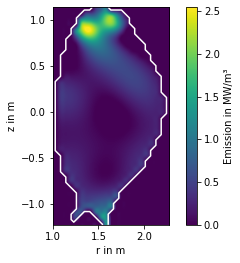

In [16]:
sample = 206

sample_emission = get_sample_emission(sample)
real_measurement = load_saved_bolometer_data(sample)
forward_measurement = get_forward_measurement(sample_emission)
mag_coords = load_magnetic_coords(sample)

params_opt_cart = optimize_params(forward_measurement, [500000, 0.1, 0.2], kernel_function="cartesian_var_z", x_point_up=True)

fit_cart_real, _ = performGP(real_measurement, PARAMS_STATIC_CART,
                            kernel_function="cartesian_var_z", 
                            magnetic_coords = mag_coords, x_point_up=True)

fit_cart_forward, _ = performGP(forward_measurement, params_opt_cart,
                            kernel_function="cartesian_var_z", 
                            magnetic_coords = mag_coords, x_point_up=True)

plot_emission(fit_cart_real)

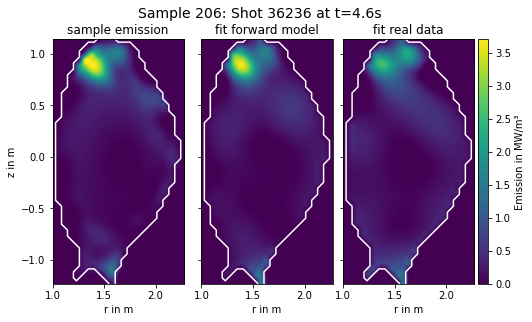

In [17]:
compare_emissions([sample_emission, fit_cart_forward,  fit_cart_real], 
                    ["Sample 206: Shot 36236 at t=4.6s", "sample emission", "fit forward model", "fit real data"], figsize=(8, 4.5))
plot_saver("../paper/sections/img/realdata206.png", dpi=350, transparent=True)

Function call 0: 1369.382
[5.e+05 1.e-01 2.e-01]
Optimization terminated successfully.
         Current function value: 1364.111947
         Iterations: 88
         Function evaluations: 164
 final_simplex: (array([[4.70947567e+05, 8.39246662e-02, 2.69887144e-01],
       [4.70946641e+05, 8.39245088e-02, 2.69887140e-01],
       [4.70947050e+05, 8.39246664e-02, 2.69887222e-01],
       [4.70947496e+05, 8.39247515e-02, 2.69887032e-01]]), array([1364.11194656, 1364.11194656, 1364.11194656, 1364.11194656]))
           fun: 1364.1119465643706
       message: 'Optimization terminated successfully.'
          nfev: 164
           nit: 88
        status: 0
       success: True
             x: array([4.70947567e+05, 8.39246662e-02, 2.69887144e-01])


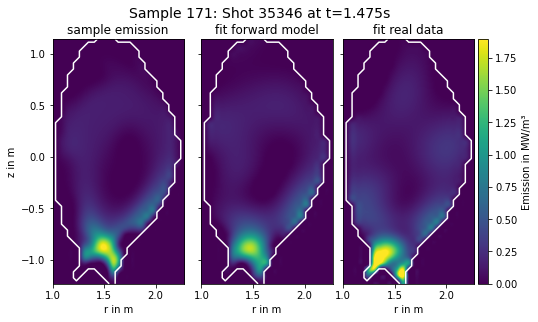

In [18]:
sample2 = 171

sample_emission3 = get_sample_emission(sample2)
real_measurement = load_saved_bolometer_data(sample2)
forward_measurement3 = get_forward_measurement(sample_emission3)
mag_coords2 = load_magnetic_coords(sample2)

params_opt_cart3 = optimize_params(forward_measurement3, [500000, 0.1, 0.2], kernel_function="cartesian_var_z", x_point_up=False)

fit_cart3, cov_cart3 = performGP(real_measurement, PARAMS_STATIC_CART,
                            kernel_function="cartesian_var_z", 
                            magnetic_coords = mag_coords2, x_point_up=False)

fit_cart4, cov_cart4 = performGP(forward_measurement3, params_opt_cart3,
                            kernel_function="cartesian_var_z", 
                            magnetic_coords = mag_coords2, x_point_up=False)

plot_emission(fit_cart3)

compare_emissions([sample_emission3, fit_cart4,  fit_cart3], 
                    ["Sample 171: Shot 35346 at t=1.475s", "sample emission", "fit forward model", "fit real data"], figsize=(8, 4.5))
plot_saver("../paper/sections/img/realdata171.png", dpi=350, transparent=True)

Function call 0: 1437.703
[5.e+05 1.e-01 2.e-01]
Function call 200: 1405.359
[9.90369010e+05 8.22651788e-02 2.42823196e-01]
Optimization terminated successfully.
         Current function value: 1405.358988
         Iterations: 111
         Function evaluations: 206
 final_simplex: (array([[9.90369538e+05, 8.22651434e-02, 2.42823305e-01],
       [9.90370259e+05, 8.22650983e-02, 2.42823328e-01],
       [9.90370371e+05, 8.22651501e-02, 2.42823338e-01],
       [9.90370142e+05, 8.22651962e-02, 2.42823269e-01]]), array([1405.35898779, 1405.35898779, 1405.35898779, 1405.35898779]))
           fun: 1405.35898779025
       message: 'Optimization terminated successfully.'
          nfev: 206
           nit: 111
        status: 0
       success: True
             x: array([9.90369538e+05, 8.22651434e-02, 2.42823305e-01])


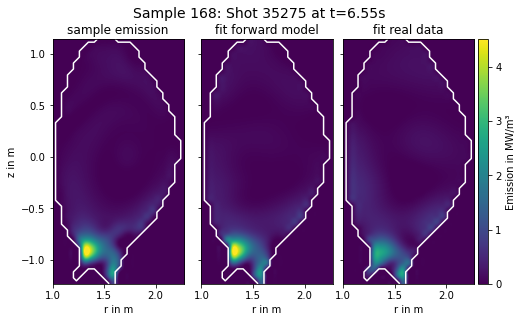

In [19]:
sample2 = 168

sample_emission3 = get_sample_emission(sample2)
real_measurement = load_saved_bolometer_data(sample2)
forward_measurement3 = get_forward_measurement(sample_emission3)
mag_coords2 = load_magnetic_coords(sample2)

params_opt_cart3 = optimize_params(forward_measurement3, [500000, 0.1, 0.2], kernel_function="cartesian_var_z", x_point_up=False)

fit_cart3, cov_cart3 = performGP(real_measurement, PARAMS_STATIC_CART,
                            kernel_function="cartesian_var_z", 
                            magnetic_coords = mag_coords2, x_point_up=False)

fit_cart4, cov_cart4 = performGP(forward_measurement3, params_opt_cart3,
                            kernel_function="cartesian_var_z", 
                            magnetic_coords = mag_coords2, x_point_up=False)

compare_emissions([sample_emission3, fit_cart4,  fit_cart3], 
                    ["Sample 168: Shot 35275 at t=6.55s", "sample emission", "fit forward model", "fit real data"], figsize=(8, 4.5))
plot_saver("../paper/sections/img/realdata169.png", dpi=350, transparent=True)

In [14]:
from src.load_data import get_sample_emission, get_synthetic_shot_time
from src.constants import PARAMS_STATIC_RMSE
sample = 203

training_emission = get_synthetic_emission(sample)
shotnumber, time = get_synthetic_shot_time(sample)
training_meas = get_measurement(training_emission)

params = [163241*1.4, 0.08, 0.20, 30204*1.4, 0.15, 10.65]

fit_emission, _ = performGP(training_meas, PARAMS_STATIC_RMSE, kernel_function="combined_var_z", shotnumber=shotnumber, time=time, x_point_up=False)

training_total = integrate_emission(training_emission)
fit_total = integrate_emission(fit_emission)

NRMSE = nrmse(training_emission, fit_emission)
SSIM = ssim(training_emission, fit_emission, data_range=training_emission.max()-training_emission.min())
PSNR = psnr(training_emission, fit_emission, data_range=training_emission.max()-training_emission.min())

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle("Training Sample {:03d}\n".format(sample) +
                "NRMSE: {},  SSIM: {},  PSNR: {}".format(round(NRMSE, 3), round(SSIM, 3), round(PSNR, 2)))

plot_emission(training_emission, fig, ax1, title="Sample: {} MW".format(round(training_total, 1))) 
plot_emission(fit_emission, fig, ax2, title="GPT: {} MW".format(round(fit_total, 1)), limits=[0, training_emission.max()])
plt.tight_layout(rect=[0,0,1,0.9])
plot_saver("emiss_synth_data_test{:03d}.png".format(sample), dpi=350, transparent=True)

ImportError: cannot import name 'get_synthetic_shot_time' from 'src.load_data' (/mnt/data/Nextcloud/Studium/gptomography-paper/code/src/load_data.py)

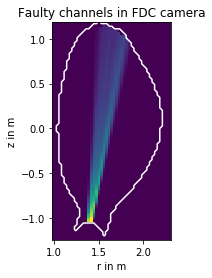

In [214]:
from src.coordinates import r_coord_full, z_coord_full
full_mask = np.loadtxt("data/mask_fullres.txt")
transfer_full = np.loadtxt("data/full_transfer_volume.txt")
fig, ax = plt.subplots(1,1)
data = np.zeros((85,47))
for channel in range(95,100):
    data += transfer_full[channel].reshape(85,47)
ax.imshow(data, extent=[r_coord_full[0], r_coord_full[-1], z_coord_full[0], z_coord_full[-1]])
ax.contour(r_coord_full, z_coord_full, full_mask[::-1], levels=[0.5], colors="white")
ax.set_xlabel("r in m")
ax.set_ylabel("z in m")
ax.set_title("Faulty channels in FDC camera")
plot_saver("faulty_bolo_FDC.png", dpi=350, transparent=True)

EQH 36173 AUGD 0
EQH 36173 AUGD 0
EQH 36173 AUGD 0
EQH 36173 AUGD 0


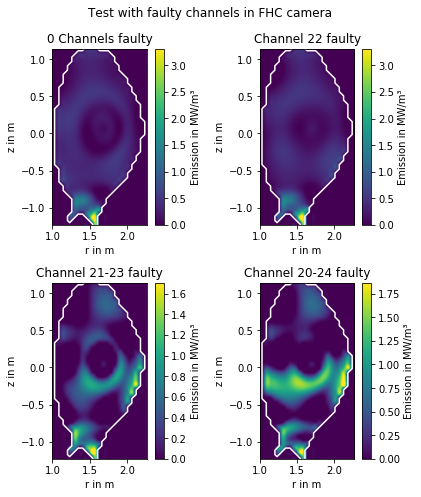

In [218]:
sample = 62

shotnumber, time = map_training_to_real_shot(sample)
real_measurement = get_saved_bolometer_data(sample)

measurement_1_faulty = real_measurement.copy()
measurement_1_faulty[21] = 5000000
measurement_3_faulty = real_measurement.copy()
measurement_3_faulty[20:23] = 5000000
measurement_5_faulty = real_measurement.copy()
measurement_5_faulty[19:24] = 5000000


fit_emission, _ = performGP(real_measurement, PARAMS_STATIC_BOTH, kernel_function="combined_var_z", shotnumber=shotnumber, time=time, x_point_up=False)
fit_emission_1_faulty, _ = performGP(measurement_1_faulty, PARAMS_STATIC_BOTH, kernel_function="combined_var_z", shotnumber=shotnumber, time=time, x_point_up=False)
fit_emission_3_faulty, _ = performGP(measurement_3_faulty, PARAMS_STATIC_BOTH, kernel_function="combined_var_z", shotnumber=shotnumber, time=time, x_point_up=False)
fit_emission_5_faulty, _ = performGP(measurement_5_faulty, PARAMS_STATIC_BOTH, kernel_function="combined_var_z", shotnumber=shotnumber, time=time, x_point_up=False)


fig, axes = plt.subplots(2,2, figsize=(6,7))
fig.suptitle("Test with faulty channels in FHC camera")

plot_emission(fit_emission, fig, axes[0][0], title="0 Channels faulty".format(round(fit_total, 1)))
plot_emission(fit_emission_1_faulty, fig, axes[0][1], title="Channel 22 faulty".format(round(fit_total, 1)))
plot_emission(fit_emission_3_faulty, fig, axes[1][0], title="Channel 21-23 faulty".format(round(fit_total, 1)))
plot_emission(fit_emission_5_faulty, fig, axes[1][1], title="Channel 20-24 faulty".format(round(fit_total, 1)))
plt.tight_layout(rect=(0,0,1,0.95))
plot_saver("faulty_emissFHC.png".format(sample), dpi=350, transparent=True)

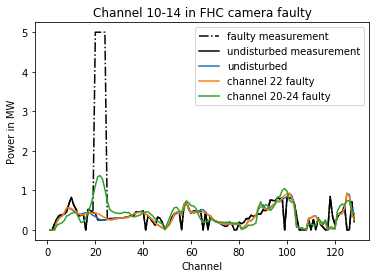

In [219]:
meas_fit = get_measurement(fit_emission)
meas_fit_1_faulty = get_measurement(fit_emission_1_faulty)
meas_fit_5_faulty = get_measurement(fit_emission_5_faulty)

plt.plot(range(1,129), measurement_5_faulty/1000000, label="faulty measurement", color="black", linestyle="-.")
plt.plot(range(1,129), real_measurement/1000000, label="undisturbed measurement", color="black")
plt.plot(range(1,129), meas_fit/1000000, label="undisturbed",)
plt.plot(range(1,129), meas_fit_1_faulty/1000000, label="channel 22 faulty", )
plt.plot(range(1,129), meas_fit_5_faulty/1000000, label="channel 20-24 faulty", )
plt.legend()
plt.title("Channel 10-14 in FHC camera faulty")
plt.ylabel("Power in MW")
plt.xlabel("Channel")
plt.plot()
plot_saver("faulty_meas_FHC.png", dpi=350, transparent=True)